# Dynamische Programmierung
## Dirkete Verfahren, volldiskretisierung

In [68]:
import numpy as np
import scipy as sp
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

from scipy.optimize import minimize, Bounds, LinearConstraint, BFGS
from scipy import sparse
import scipy.signal as sig

## 1. Model

In [ ]:
global nx, nu, nxu, N, t, Ta, S, M, Q, R, b_


t_end = 4
N = 50
t = np.linspace(0,t_end,N)

# Anzahl an Zuständen und Eingängen
nx = 4
nu = 1
nxu = nx+nu

Ta = t_end/N

S = np.zeros((nx,nx))
S[2,2] = 5

M = np.eye(4)
Q = np.eye(4)
R = np.array([[0.1]])
b_ = [0,0,0,0]

In [ ]:
# Parameter
global J,a,m,d,g

J = 0.0361  # kgm²
a = 0.42    # m
m = 0.3553  # kg
d = 0.005   # Nms
g = 9.81    # m/s²

In [ ]:
# System dynamic

def System_dynamic(x,u):
    dx = np.zeros(nx)
    dx[0] = x[1]
    dx[1] = (m*g*np.sin(x[1])+m*a*np.cos(x[0])*u-d*x[1])/(J+m*a**2) 
    dx[2] = x[3]
    dx[3] = u

    return dx



In [ ]:
# Ableitungen

def dfdx(x,u):    
    A =np.zeros((nx,nx))
    A[0,1] = (m*g*np.cos(x[0])-m*a*np.sin(x[0])*u)/(J+m*a**2)   
    A[1,1] = -d/(J+m*a**2)                                      
    A[2,3] = 1                                                  
    return A

def dfdu(x,u):    
    B = np.zeros((nx,nu))                                        
    B[1,0] = (m*a*np.cos(x[0]))/(J+m*a**2)                        
    B[3,0] = 1                                                    
    return B


## Minimization with Scipy minimize
### Setup Problem

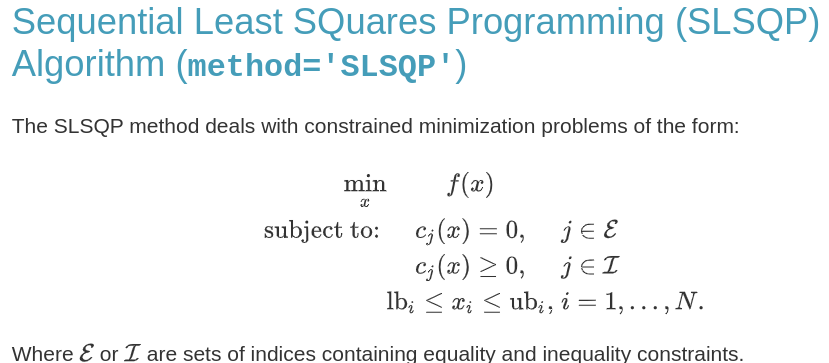

In [ ]:
# Kostenfunktion

l  = lambda x,Q: 1+x.T@Q@x/2
dl = lambda x,Q: Q@x               


def cost(y):
    # y = [x0 u0, x1 u1, ....., xN uN]   mit x = [x0 x1 x2 x3 ..], und u = [u0,u1,u2,u3,...]     
    
    cost_ = y[-nxu:-nu]@S@y[-nxu:-nu]/2    # Endkostenterm 0.5*xSx
    
    for k in range(0,N-1):
        k0 = (k)*nxu      
        k1 = (k+1)*nxu            
        cost_ += (t[k+1]-t[k])/2*( l(y[k0:k0+nxu], block_diag(Q,R))+ l(y[k1:k1+nxu],block_diag(Q,R)) )    #  laufende Kosten  1 + 0.5*(xQx + uRu)
               
    return cost_

def costdx(y):
    # Ableitung der Kosten      
    
    dJdy = np.zeros((nxu*N))
    dJdy[-nxu:] = dl(y[-nxu:],block_diag(S,R*0))   
    for k in range(0,N-1):
        k0 = (k)*nxu      
        k1 = (k+1)*nxu    
        #print(k0,k1)  
        dJdy[k0:k1] = (t[k+1]-t[k])/2*( dl(y[k0:k0+nxu],block_diag(Q,R))+ dl(y[k1:k1+nxu],block_diag(Q,R)) )     
    
    return dJdy


#y_ = np.ones(N*nxu)*2

#cost(y_)
#a_ = df_eq_cons(y_)
#a_ = a_*100

#print(np.array([a_[:14,:14]],int))




In [ ]:
global x0, xN, xNN, X0
x0 = np.array([np.pi,0,0,0])
#x0 = np.array([2,2,2,2])
xN = np.array([0,0,0.0,0])
xNN = np.array([0,0,0,0,0])


xmin = np.array([-np.inf, -np.inf, -0.7, -np.inf])
xmax = np.array([np.inf, np.inf, 0.7, np.inf])
umin = np.array([-10])
umax = np.array([10])

# y = [x0 u0, x1 u1, ......., x_N u_N]

Ad,Bd,Cd,Dd,Ta = sig.cont2discrete((dfdx(x0,0.1),dfdu(x0,0.1),np.zeros((nx,nu)),0),Ta, method='zoh')


# - quadratic objective

P = sparse.block_diag([sparse.kron(sparse.eye(N-1),  sparse.block_diag([Q,R])), sparse.block_diag([S,R*0]) ], format='csc')

Aeq =  sparse.kron(sparse.eye(N),np.hstack([-np.eye(nx),np.zeros((nx,nu))]) ) + sparse.kron(sparse.eye(N, k=-1), np.hstack([Ad,Bd]))

leq = np.hstack([-x0, np.zeros((N-2)*(nx)), -xN])
ueq = leq.copy()


# Inequality constraints, like input and state constraints
Aineq = sparse.eye(N*(nx+nu))
#print(nx+nu)
lineq =  np.kron(np.ones(N), np.hstack([xmin, umin]))
uineq =  np.kron(np.ones(N), np.hstack([xmax, umax]))


# - OSQP constraints
Ab = sparse.vstack([Aeq, Aineq], format='csc')
lb = np.hstack([leq, lineq])
ub = np.hstack([ueq, uineq])

X0 = np.hstack([x0,0, np.zeros((N-2)*(nx+nu)), xN@M,0])
#eq_const = [-x0,np.zeros(nu*nx*N)  ]

#print(P.toarray())

print(np.shape(Aeq))
print(np.shape(leq))
#print(np.shape(ueq))

#print(Aeq.toarray())

#print(Aeq.toarray())
#print(Ax.toarray())
#print(np.array([Aeq.toarray()], int))



In [ ]:
from scipy.optimize import NonlinearConstraint
# Bounds  --> x, u
bounds = Bounds(lineq, uineq)

# Equality Constraints
linear_constraint = LinearConstraint(Aeq,leq, ueq)
#linear_constraint = NonlinearConstraint(f_eq_cons, leq,ueq)

res_lin = minimize(cost, X0, method='SLSQP', jac=costdx,
               constraints=linear_constraint, options={'ftol': 1e-9 , 'disp': True},
               bounds=bounds)



In [ ]:
def f_eq_cons(y):
    xeq = np.zeros(nx*N)
    xeq[:nx] =  x0-y[:nx]                # Startwert    
    xeq[-nx:] = xN-M@y[-nxu:-nu] + b_   # Endwert
    
    for i in range(1,N-1):               
        k, k1 = i*nxu, (i+1)*nxu         
        #dx[i*nx:i*nx+nx] =  y[k1:k1+nx] -y[k:k+nx] - (t[i+1]-t[i])/2*(System_dynamic(y[k:k+nx],y[k+nx:k+nxu]) + System_dynamic(y[k1:k1+nx],y[k1+nx:k1+nxu]))
        
        dt = t[i+1]-t[i]
        # Runge Kutta
        #dx[i*nx:i*nx+nx] =  y[k1:k1+nx] -y[k:k+nx]  -dt/2*(y[k:jḱ+nx] + runge_kutta_k4(System_dynamic,y[jḱ:k+nx],y[k+nx:k+nxu],dt))  
        # Vorwärtsdiferenzen
        x = y[k:k+nx]
        u =  y[k+nx:k+nxu]
        #xeq[i*nx:i*nx+nx] =  y[k1:k1+nx] -y[k:k+nx]  -dt*(dfdx(x,u)@x +dfdu(x,u)@u)       
        xeq[i*nx:i*nx+nx] =  y[k1:k1+nx] -y[k:k+nx]*0  -(Ad@x +Bd@u)   
    return xeq



def df_eq_cons(y):
    dx = np.zeros((N*nx,N*nxu))
    
    #dx[:nx,:nxu] =  np.hstack([ -np.eye(nx), np.zeros((nx,nu)) ])    # Startdynamik
    dx[-nx:,-nxu:-nu] = M                                            # Enddynamik
    
    for i in range(1,N-1):
        k, k1 =   i*nxu, (i+1)*nxu

        x, x1 = y[k:k+nx] , y[k1:k1+nx]
        u, u1 = y[k+nx:k+nxu], y[k1+nx:k1+nxu] 

        dt = (t[i+1]-t[i])/2
        #  dx[i] = [A | B | -I | 0]
        #dx[i*nx:(i+1)*nx,k-nxu:k+2*nxu-nxu] = np.hstack([ dt*dfdx(x,u),dt*dfdu(x,u) ,  -np.eye(nx) -dt*dfdx(x1,u1),-dt*dfdu(x1,u1) ]) 
        #dx[i*nx:(i+1)*nx,k-nxu:k+2*nxu-nxu] = np.hstack([ -np.eye(nx)-dt*dfdx(x,u),-dt*dfdu(x,u) ,  np.eye(nx) ,np.zeros((nx,nu)) ]) 
        dx[i*nx:(i+1)*nx,k-nxu:k+2*nxu-nxu] = np.hstack([ -Ad , -Bd, -np.eye(nx) ,np.zeros((nx,nu)) ]) 
        
        #  dx[i] = [-A | -B | -A | -B]
        #dx[i*nx:(i+1)*nx,k:k+2*nxu] = np.hstack([ -dt*dfdx(y[k:k+nx],y[k+nx:k+nxu]),-dt*dfdu(y[k:k+nx],y[k+nx:k+nxu]) ,  -dt*dfdx(y[k1:k1+nx],y[k1+nx:k1+nxu]),-dt*dfdu(y[k1:k1+nx],y[k1+nx:k1+nxu])   ])    
        
        #  dx[i] = [-I-A | -B | I-A | -B]        
        #dx[i*nx:(i+1)*nx,k:k+2*nxu] = np.hstack([ - np.eye(nx) -dt*dfdx(x,u),-dt*dfdu(x,u) ,  np.eye(nx) -dt*dfdx(x1,u1),-dt*dfdu(x1,u1) ]) 

        #  dx[i] = [ -A | B | I | 0]        
        #dx[i*nx:(i+1)*nx,(k-nxu):(k-nxu)+2*nxu] = np.hstack([ -dt*dfdx(x,u), -dt*dfdu(x,u) ,  np.eye(nx), np.zeros((nx,nu))]) 
    
    return dx


def df_eq_cons2(y):
    dx = np.zeros(N*nxu)
    
    dx[:nxu] =  np.hstack([ np.eye(nx)@y[:nx], np.zeros(nu) ])          # Startdynamik
    dx[-nx:] = M@y[-nxu:-nu]                                            # Enddynamik
    
    for i in range(1,N-1):
        k, k1 =   i*nxu, (i+1)*nxu
        x, x1 = y[k:k+nx] , y[k1:k1+nx]
        u, u1 = y[k+nx:k+nxu], y[k1+nx:k1+nxu] 

        dt = (t[i+1]-t[i])/2
        #  dx[i] = [A | B | -I | 0]
        #dx[i*nx:(i+1)*nx,k-nxu:k+2*nxu-nxu] = np.hstack([ dt*dfdx(x,u),dt*dfdu(x,u) ,  -np.eye(nx) +-dt*dfdx(x1,u1),-dt*dfdu(x1,u1) ]) 
        
        #  dx[i] = [-A | -B | -A | -B]
        #dx[i*nx:(i+1)*nx,k:k+2*nxu] = np.hstack([ -dt*dfdx(y[k:k+nx],y[k+nx:k+nxu]),-dt*dfdu(y[k:k+nx],y[k+nx:k+nxu]) ,  -dt*dfdx(y[k1:k1+nx],y[k1+nx:k1+nxu]),-dt*dfdu(y[k1:k1+nx],y[k1+nx:k1+nxu])   ])    
        
        #  dx[i] = [-I-A | -B | I-A | -B]        
        #dx[i*nx:(i+1)*nx,k:k+2*nxu] = np.hstack([ -np.eye(nx) -dt*dfdx(x,u),-dt*dfdu(x,u) ,  np.eye(nx) -dt*dfdx(x1,u1),-dt*dfdu(x1,u1) ]) 

        #  dx[i] = [ -A | B | I | 0]        
        dx[i*nx:(i+1)*nx] =  -dt*dfdx(x,u)@x -dt*dfdu(x,u)@u +  np.eye(nx)@x1

    return dx
y_=np.ones(N*nxu)
x_ = df_eq_cons2(y_)
#print(np.array([10*x_],int))
#dfdu([1,1,1,1],[1])@[1] + M@[1,1,1,1]

In [ ]:

# Bounds  --> x, u
bounds = Bounds(lineq, uineq)

# Constraints
eq_cons = {'type': 'eq',
           'fun' : f_eq_cons,
           'jac' : df_eq_cons
           }

nonlinear_constraint = NonlinearConstraint(f_eq_cons, np.zeros(N*nx), np.zeros(N*nx))

#method = 'SLSQP'  
# trust-constr
res = minimize(cost, X0, method='trust-constr', jac=costdx,
               constraints=eq_cons, options={'disp': True},
               bounds=bounds)



In [167]:
# Simulate the dynamiks
from scipy.integrate import solve_ivp
def runge_kutta_k4(f,x,u,h=1):
        
    #RK4 integration with zero-order hold on u    
    f1 = f(x, u)
    f2 = f(x + 1/2*h*f1, u)
    f3 = f(x + 1/2*h*f2, u)
    f4 = f(x + h*f3, u)

    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)

def close_loop(res):
    xhist = np.zeros((nx,N))    
    uhist = np.zeros((nu,N))  

    uhist[0,:]=  res.x[4::5]
    #uhist[0,:] = sol.value(u)
    xhist[:,0] = x0

    for k in range(0,N-1):                                               
         
        xhist[:,k+1] =  np.array(runge_kutta_k4(System_dynamic, xhist[:,k], uhist[0,k],h=Ta)).flatten()
       
              
    return xhist,uhist


In [168]:
xhist,uhist = close_loop(res)
#xhist,uhist = close_loop(res_lin)

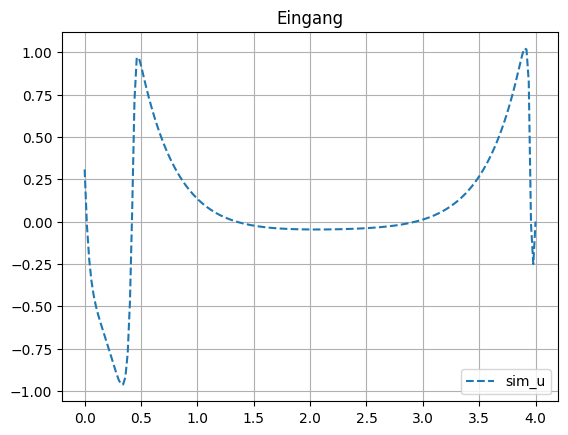

In [170]:
plt.plot(t,res.x[4::5], label = 'u')
plt.plot(t,uhist[0,:], label='sim_u', linestyle='--')
plt.title('Eingang')
plt.grid()
plt.legend()

NameError: name 'res' is not defined

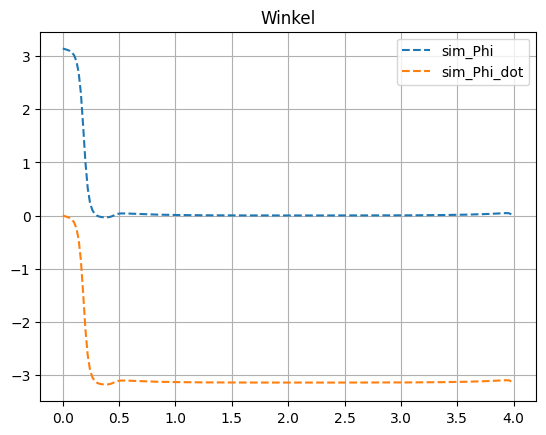

In [171]:
#plt.plot(t,res.x[0::5], label = 'Phi [rad]')
#plt.plot(t,res.x[1::5], label = 'Phi dot [rad/s]')
plt.plot(t,xhist[0,:],   label='sim_Phi', linestyle='--')
plt.plot(t,xhist[1,:],   label='sim_Phi_dot', linestyle='--')
plt.title('Winkel')
plt.grid()
plt.legend()
print(res.x[0:5])

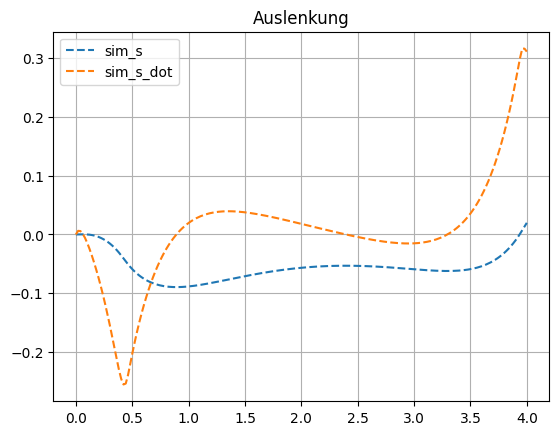

In [172]:
plt.plot(t,res.x[2::5], label = 's [m]')
plt.plot(t,res.x[3::5], label = 'v [m/s]')
plt.plot(t,xhist[2,:],   label='sim_s', linestyle='--')
plt.plot(t,xhist[3,:],   label='sim_s_dot', linestyle='--')
plt.title('Auslenkung')
plt.grid()
plt.legend()

# CASADI 

In [1]:
import numpy as np
from casadi import *
from casadi import SX, DM, MX
from math import cos, sin

In [97]:
from casadi import *

# Declare variables
x = SX.sym("x",2)

# Form the NLP
f = x[0]**2 + x[1]**2 # objective
g = x[0]+x[1]-10      # constraint
nlp = {'x':x, 'f':f, 'g':g}

# Pick an NLP solver
MySolver = "ipopt"
#MySolver = "worhp"
#MySolver = "sqpmethod"

# Solver options
opts = {}
if MySolver=="sqpmethod":
  opts["qpsol"] = "qpoases"
  opts["qpsol_options"] = {"printLevel":"none"}

# Allocate a solver
solver = nlpsol("solver", MySolver, nlp, opts)

# Solve the NLP
sol = solver(lbg=0)

# Print solution
print("-----")
print("objective at solution = ", sol["f"])
print("primal solution = ", sol["x"])
print("dual solution (x) = ", sol["lam_x"])
print("dual solution (g) = ", sol["lam_g"])

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+01 6.67e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [98]:
# Parameter
global J,a,m,d,g

J = 0.0361  # kgm²
a = 0.42    # m
m = 0.3553  # kg
d = 0.005   # Nms
g = 9.81    # m/s²

In [99]:
S = np.zeros((nx,nx))
S[2,2] = 5

M = np.eye(4)
Q = np.eye(4)
R = np.array([[0.1]])

In [149]:
# Gerneral
N = 200   #% number of control intervals
T = 4    #Time horizon [s]
t = np.linspace(0,T,N)
dt = T/N
nx = 4
nu = 1


# Declare variables
x = SX.sym("x",nx)

opti = casadi.Opti()

# Minimiere x und u
x = opti.variable(4,N) # State vector [Theta, Omega, s, v]
u = opti.variable(1,N) # Control vector

# System dynamic
def System_dynamic(x,u):
    
    phidot= x[1]
    phiddot = (m*g*np.sin(x[1])+m*a*np.cos(x[0])*u-d*x[1])/(J+m*a**2) 
    v = x[3]
    vdt = u

    return vertcat(phiddot, phiddot, v, vdt)

# Cost function
def cost(x,u):
    # y = [x0 u0, x1 u1, ....., xN uN]   mit x = [x0 x1 x2 x3 ..], und u = [u0,u1,u2,u3,...]     
        
    cost_ = x[:,N-1].T@S@x[:,N-1]/2    # Endkostenterm 0.5*xSx
    
    for k in range(0,N-2):           
        cost_ += dt*(1+x[:,k].T@Q@x[:,k])/2    #  laufende Kosten  1 + 0.5*(xQx + uRu)       
        cost_ += dt*R*u[k]**2/2
    return cost_

# Dynamic Constraints
# with Forwardiff
for k in range(0,N-1):
    opti.subject_to(x[:,k+1] == x[:,k] + System_dynamic(x[:,k],u[:,k])*dt)

# Boundary Conditions
x0 = [np.pi,0,0,0] 
xN = [0,0,0,0]

opti.subject_to(x[:,0] == x0)
opti.subject_to(x[0,N-1] == 0)

opti.subject_to(x[1,N-1] <= 10.5)
opti.subject_to(x[1,N-1] >= -10.5)

# Path constraints
opti.subject_to(x[2] <= 0.7)
opti.subject_to(x[2] >= -0.7)

opti.subject_to(u <=  10)
opti.subject_to(u >= -10)

# Cost-function
 
opti.minimize(cost(x,u))

# Solve
opti.set_initial(u[:],-0.2) #; % Initial guess for mass
opti.set_initial(x[:,0], x0 )
#opti.set_initial(x[:,-1], xN )

opti.solver('ipopt')
sol = opti.solve()


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2791
Number of nonzeros in inequality constraint Jacobian.:      404
Number of nonzeros in Lagrangian Hessian.............:     2389

Total number of variables............................:     1000
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      801
Total number of inequality constraints...............:      404
        inequality constraints with only lower bounds:      202
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      202

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0866160e+00 3.15e+00 1.70e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [146]:
opti.debug.value
opti.debug.show_infeasibilities()
#opti.debug.value(x,opti.initial())

Violated constraints (tol 0), in order of declaration:
------- i = 0/1206 ------ 
0 <= -0.0065523 <= 0 (viol 0.0065523)
Opti constraint of shape 4x1, defined at /tmp/ipykernel_7230/1663256107.py:43
At nonzero 0.
------- i = 1/1206 ------ 
0 <= 0.0069852 <= 0 (viol 0.0069852)
Opti constraint of shape 4x1, defined at /tmp/ipykernel_7230/1663256107.py:43
At nonzero 1.
------- i = 2/1206 ------ 
0 <= 1.08736e-22 <= 0 (viol 1.08736e-22)
Opti constraint of shape 4x1, defined at /tmp/ipykernel_7230/1663256107.py:43
At nonzero 2.
------- i = 3/1206 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 4x1, defined at /tmp/ipykernel_7230/1663256107.py:43
At nonzero 3.
------- i = 4/1206 ------ 
0 <= -0.0016978 <= 0 (viol 0.0016978)
Opti constraint of shape 4x1, defined at /tmp/ipykernel_7230/1663256107.py:43
At nonzero 0.
------- i = 5/1206 ------ 
0 <= 0.00163881 <= 0 (viol 0.00163881)
Opti constraint of shape 4x1, defined at /tmp/ipykernel_7230/1663256107.py:43
At nonzero 1.
------- i = 6/120

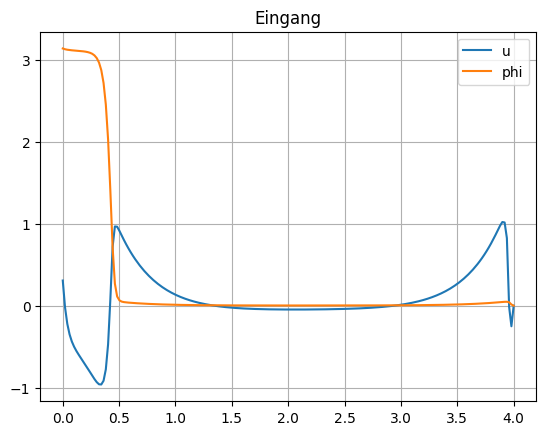

In [151]:
#% Post-processing
t = np.linspace(0,T,N)
plt.plot(t,sol.value(u), label = 'u')
plt.plot(t,sol.value(x[0,:]), label = 'phi')

plt.title('Eingang')
plt.grid()
plt.legend()